In [1]:
import pythtb as tb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import spglib as spg
import logging
_logger = logging.getLogger(__name__)

In [2]:
class Orbital(object):
    """ Orbital object with a onsite energy """
    def __init__(self, onsite, label):
        """
        Initialize an instance of orbital
        
        :type  onsite: float
        :param onsite: The onsite energy of the orbital
        
        :type  label: string
        :param label: The name of the orbital (examples: s,p,d,f)
        """
        self.label = label
        self.onsite = onsite

    def __repr__(self):
        """ Representation of the orbital object """
        return "{} with onsite {}\n".format(self.label, self.onsite)

In [3]:
class Atom(object):
    """ Atom object hosting orbitals """
    def __init__(self, position, number):
        """ Initialize an instance of atom
        
        :type  position: ndarray, list, tuple
        :param position: The onsite energy of the orbital
        
        :type  number: int
        :param number: The atomic number of the atom (Z)
        """
        position = np.asarray(position)
        self.number = number
        self.position = position
        self.orbitals = []
    
    def add_orbital(self, orbital):
        """ Add an orbital to the hosting atom
        :type  orbital: orbital object
        :param orbital: an orbital in the atom
        """
        existing = False
        for existing_orbital in self.orbitals:
            if orbital.label == existing_orbital.label:
                existing = True
        if not existing:
            self.orbitals.append(orbital)
            return "Placed {} orbital with onsite {}, on {}".format(orbital.label,orbital.onsite, self)
        else:
            _logger.warning("An orbital with label {} allready exist, try different label.".format(orbital.label))
        
        
    def number_of_orbitals(self):
        """ Returns the number of orbitals in the atom 
        :returns: the number of orbitals in the atom
        """
        return len(self.orbitals)     
    
    def __repr__(self):
        """ Representation of the Atom object """

        return "Atom with Z={} at {}".format(self.number, self.position)
    
class Oxygen(Atom):
    """ A special case of Atom designed for Oxygen"""
    def __init__(self, position):
        Atom.__init__(self, position, 8)
        self.add_orbital(Orbital(-19.046, "S"))
        self.add_orbital(Orbital(  4.142, "Pz"))
        self.add_orbital(Orbital(  4.142, "Px"))
        self.add_orbital(Orbital(  4.142, "Py"))
    
    def __repr__(self):
        return "Oxygen at {}".format(self.position)
    
class Zinc(Atom):
    """ A special case of Atom designed for Zinc"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(  1.666, "S"))
        self.add_orbital(Orbital( 12.368, "Pz"))
        self.add_orbital(Orbital( 12.368, "Px"))
        self.add_orbital(Orbital( 12.368, "Py"))
        
    def __repr__(self):
        return "Zinc at {}".format(self.position)
    

class Gallium(Atom):
    """ A special case of Atom designed for Gallium"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(  1.438, "S"))
        self.add_orbital(Orbital( 10.896, "Pz"))
        self.add_orbital(Orbital( 10.896, "Px"))
        self.add_orbital(Orbital( 10.896, "Py"))
    
    def __repr__(self):
        return "Gallium at {}".format(self.position)
    
class Nitrogen(Atom):
    """ A special case of Atom designed for Nitrogen"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(-11.012, "S"))
        self.add_orbital(Orbital(  0.005, "Pz"))
        self.add_orbital(Orbital(  0.005, "Px"))
        self.add_orbital(Orbital(  0.005, "Py"))
        
    def __repr__(self):
        return "Nitrogen at {}".format(self.position)   

In [4]:
class Crystal:
    def __init__(self, lattice):
        """ Initialize an instance of crystal with lattice hosting atom objects
        
        :type  lattice: ndarray
        :param lattice: a 3x3 array with lattice parameters [a,b,c]
        """

        self.atoms = []
        self.setLattice(lattice)
        
    def setLattice(self, lattice):
        """ Sett lattice parameters and calculate relevant properties 
        
        :type  lattice: ndarray
        :param lattice: a 3x3 array with lattice parameters [a,b,c]
        """
        self.lattice = lattice
        self.a = lattice[0]
        self.b = lattice[1]
        self.c = lattice[2]
        
        self._setVolume()
        self._setSpaceGroup()
        self._setBrillouinZone()
        
    def _setVolume(self):
        """ Calculate the volume of the crystal"""
        self.volume = np.dot(self.a, np.cross(self.b, self.c))
        
    def _setSpaceGroup(self):
        self.spacegroup = spg.get_spacegroup(
            (self.lattice,
             self.getAtomPositons(),
             self.getAtomNumbers()), 
             symprec=1e-5)
        
    def _setBrillouinZone(self):
        self.brillouinZone = BrillouinZone(self)
        
    def add_atom(self,atom):
        """ Add an atom object to the crystal
        :type  atom: atom object
        :param atom: the instance of atom to be placed in the crystal
        """
        existing = False
        for existing_atom in self.atoms:
            if np.all(atom.position == existing_atom.position):
                existing = True
        if not existing:
            atom.position = self._reduceCoordinate(atom.position)
            self.atoms.append(atom)
            self._setSpaceGroup()
            self._setBrillouinZone()
            return "Placed atom at {}".format(atom.position)
        else:
            _logger.warning("An atom is already at {}, try another coordinate.".format(atom.position))
    
    def getAtomNumbers(self):
        numbers = []
        for atom in self.atoms:
            numbers.append(atom.number)
        #if not numbers:
        #    _logger.warning("No atoms found, will give number 0 as a substitute")
        #    return [0]
        #else:
        return numbers

    def getAtomPositons(self):
        positions = []
        for atom in self.atoms:
            positions.append(atom.position)
        #if not positions:
        #    _logger.warning("No atoms found, will give position [0, 0, 0] as a substitute")
        #    return [[0, 0, 0]]
        #else:
        return positions         
            
    def _reduceCoordinate(self, coordinate):
        if np.any(coordinate>=np.array([1, 1, 1])) or np.any(coordinate<np.array([0, 0, 0])):
            _logger.warning("Coordinate {} oustide cell, reduces to a closer coordinate.".format(coordinate))
            coordinate = coordinate-(coordinate>=np.array([1, 1, 1]))*1
            coordinate = coordinate+(coordinate<np.array([0, 0, 0]))*1

            return self._reduceCoordinate(coordinate)
        else:
            return coordinate
            
    def __repr__(self):
        """ Representation of the crystal object """
        string = "CRYSTAL:\nSpacegroup: {}\n\nLattice:\n{}\nAtoms:\n".format(self.spacegroup,self.lattice)
        
        for i, atom in enumerate(self.atoms):
            string += "{}: {}\n".format(i,atom)
        return string

In [5]:
class Band:
    
    def __init__(self, k_grid, k_list, energies, waves):
        """ Create instance of Band with a k-grid, energies and waves
        
        :type  k_grid: ndarray
        :param k_grid: A Nx3 array representing N k-points for the energies
        
        :type  energies: ndarray
        :param energies: A vector of N energy-elements corresponding to the k-grid
        
        :type  waves: ndarray
        :param waves: A NxM array containing N wave vectors of length M representing orthogonal wavefunctions
        """
        
        self.k_grid = k_grid
        self.k_list = k_list
        if energies.shape[0] != k_grid.shape[0]:
            _logger.warning("Shape of energy ({}) does not match the length of the k-grid ({})".format(energies.shape,k_grid.shape[0]))
        else:
            self.energies = energies
        if energies.shape[0] != waves.shape[0]:
            _logger.warning("First dimension of waves ({}) does not match the shape of energies ({})".format(waves.shape,energies.shape))
        else:
            self.waves = waves
            
        
    def __repr__(self):
        """ Representing band object """
        return "Band object, E_min: {}, E_max: {}".format(np.min(self.energies).round(2),np.max(self.energies).round(2))

In [6]:
class BrillouinZone:
    def __init__(self, crystal):
        """ Initialize an instance of Brillouin Zone with reciprocal lattice hosting band objects
        
        :type  lattice: ndarray
        :param lattice: a 3x3 array with lattice parameters [a*,b*,c*]
        """
        self._setReciprocalSpace(crystal)
        
        self.bands = []     

    def _setReciprocalSpace(self, crystal):
        """ Constructs the reciprocal space from a crystal objec
        
        :type  crystal: crystal object
        :param crystal: the crystal object containing real space information
        """
        self.a = np.cross(crystal.b, crystal.c) / crystal.volume * 2*np.pi #reciprocal aangstrom
        self.b = np.cross(crystal.c, crystal.a) / crystal.volume * 2*np.pi #reciprocal aangstrom
        self.c = np.cross(crystal.a, crystal.b) / crystal.volume * 2*np.pi #reciprocal aangstrom

        self.lattice = np.vstack([self.a, self.b, self.c])

    def add_band(self,band):
        """ Add a band object to the Brillouin Zone
        
        :type  atom: band object
        :param atom: the instance of atom to be placed in the crystal
        """
        existing = False
        for existing_band in self.bands:
            if band == existing_band:
                existing = True
        if not existing:
            self.bands.append(band)
        else:
            raise _logger.warning("An equal band already exist")
            
    def __repr__(self):
        """ Representation of the Brillouin Zone object """
        return "Brillouin Zone\nLattice:\n{}\n\nBands:\n{}".format(self.lattice, self.bands)
    

In [7]:
class AtomMatrix:
    """ A matrix containing all transition matrices between atoms """
    def __init__(self, crystal):
        """ Create instance of atom matrix
        :type  crystal: crystal object
        :param crystal: a crystal containing atoms
        """
        self.atom_matrix = []
        
        for i,initial_atom in enumerate(crystal.atoms):
            atom_matrix_row = []    

            for final_atom in crystal.atoms:    
                transition_matrix = TransitionMatrix(initial_atom, final_atom)

                if initial_atom == final_atom:
                    for i, orbital in enumerate(initial_atom.orbitals):
                        transition_matrix[i][i] = orbital.onsite
                        
                atom_matrix_row.append(transition_matrix)
                
            self.atom_matrix.append(atom_matrix_row)

    def __getitem__(self, index):
        """ Get a transition matrix by the index of initial and final atom [i][f]"""
        return self.atom_matrix[index]
                
    def __repr__(self):
        """ Representation of the atom matrix object"""
        string = "Atom matrix:\n"
        for i, atom_matrix_row in enumerate(self.atom_matrix):
            for f, transition_matrix in enumerate(atom_matrix_row):
                string += "[{},{}]".format(i,f)
            string += "\n"
        string += "\n"
        for i, atom_matrix_row in enumerate(self.atom_matrix):
            for f, transition_matrix in enumerate(atom_matrix_row[i:]):
                string += "[{},{}]\n{}\n\n".format(i,f,transition_matrix)
        return string

In [8]:
class TightBinding:
    """ Tight binding class constructed around the pythTB package """
    def __init__(self, crystal):
        """ Create instance of the Tight binding model 
        
        :type  crystal: crystal object
        :param crystal: a crystal object containing atoms
        """
        
        self.crystal = crystal
        self.crystal.brillouinZone.band_model = "Tight Binding"
        self.spg = (crystal.lattice, crystal.getAtomPositons(), crystal.getAtomNumbers())
        
        self._orbital_positons = []
        for atom in crystal.atoms:
            for orbital in atom.orbitals:
                self._orbital_positons.append(atom.position)        
        
        self.setGrid()
        self.model = tb.tb_model(3,3,self.crystal.lattice, self._orbital_positons)
        
    def setGrid(self, mesh=3):
        """ Define the resolution of the reciprocal space
        
        :type  mesh: ndarray, list, int
        :param mesh: The number of point along a reciprocal latticevector
        """
        if isinstance(mesh, (float, int)):
            mesh = np.ones((3,),dtype=np.int)*int(mesh)

        if isinstance(mesh, (list, tuple)):
            mesh = np.asarray(mesh)

        if isinstance(mesh, np.ndarray):
            self.crystal.brillouinZone.mesh = mesh
            mapping, grid = spg.get_ir_reciprocal_mesh(mesh, self.spg, is_shift=[0, 0, 0])
            
            if np.any(mesh==np.array([1, 1, 1])):
                mesh+= (mesh==np.array([1, 1, 1]))*1
            k_grid = grid[np.unique(mapping)]/(mesh-1)

            k_list = []
            for i, map_id in enumerate(mapping[np.unique(mapping)]):
                k_list.append((grid[mapping==map_id]/(mesh-1)).tolist()) #np.dot(,self.cell.brillouinZone)
            self.k_grid = k_grid
            self.k_list = k_list
        else:
            _logger.warning("Unknown type {} for mesh, try ndarray.".format(type(mesh)))
        
        
    def display_pythtb(self):
        """ Displat the info from pythTB """
        self.model.display()
        
    def calculate(self, eig_vectors = False):
        """ Calculate band energies for the given k-points and place them as band objects in the crystal, 
        NB! replaces the full band structure
        
        :type  eig_vectors: bool
        :param eig_vectors: if eigen vectors are returned
        """
        self.crystal.brillouinZone.bands = []
        
        if eig_vectors:
            energies, waves = self.model.solve_all(self.k_grid,eig_vectors=eig_vectors)
        else:
            energies = self.model.solve_all(self.k_grid,eig_vectors=eig_vectors)
            waves = np.stack([np.zeros(energies.shape),np.ones(energies.shape)], axis=2)
        
        for i, band in enumerate(energies):
            self.crystal.brillouinZone.add_band(Band(k_grid=self.k_grid, k_list=self.k_list, energies=band, waves=waves[i]))

    
    def bandstructure(self, ylim=(None,None), color=None, ax=None):
        """ Plot a representation of the band structure
        
        :type  ylim: tuple, list
        :param ylim: lower and upper limit of y-values (ymin,ymax)
        """

        """ seekpath automatic lines"""
        #path = sp.get_explicit_k_path((lattice, positions, numbers), False, recipe="hpkot", threshold=1e-5,reference_distance=1)
        #expath = path['explicit_kpoints_abs'][:5]
        #labels = path['explicit_kpoints_labels'][:5]

        """ manual lines"""
        path=[[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0,0.0],[0.0,0.0,0.0],[0,0,0.5],[2./3.,1./3.,0.5],[2./3.,1./3.,0.0],[0,0,0]]
        label=(r'$A $',      r'$L$',       r'$M$',   r'$\Gamma$', r'$A $', r'$H$',  r'$K$',r'$\Gamma $')

        
        # call function k_path to construct the actual path
        (k_vec,k_dist,k_node)=self.model.k_path(path,301,report=False)

        evals =self.model.solve_all(k_vec)
        
        fig = None
        if not ax:
            fig, ax = plt.subplots(figsize=(8,6))
            fig.tight_layout()

            ax.set_title("Bandstructure for Zno based on Kobayashi")
            ax.set_ylabel("Band energy")

            # specify horizontal axis details
            ax.set_xlim([0,k_node[-1]])
            # put tickmarks and labels at node positions
            ax.set_xticks(k_node)
            ax.set_xticklabels(label)
            # add vertical lines at node positions

            for n in range(len(k_node)):
                if label[n] == r'$\Gamma$':
                    ax.axvline(x=k_node[n],linewidth=1, color='k')
                else:
                    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
    
        for band in evals:
            ax.plot(k_dist, band, color=color)

        if not fig:
            return ax
        else:
            ax.set_ylim(ylim)
            return ax, fig

    def __repr__(self):
        return "Parabolic band model for: \n \n {} \n".format(self.crystal)

In [9]:
class ParabolicBand:
    """ Parabolic band class constructed for simple simulations """
    HBAR_C = 1973 #eV AA
    M_E = .511e6 #eV/c^2
    
    def __init__(self, crystal):
        """ Create instance of the Parabolic Band model 
        
        :type  crystal: crystal object
        :param crystal: a crystal object containing atoms
        """
        
        self.crystal = crystal
        self.crystal.brillouinZone.band_model = "Parabolic"
        self.spg = (crystal.lattice, crystal.getAtomPositons(), crystal.getAtomNumbers())
        
        self._orbital_positons = []
        for atom in crystal.atoms:
            for orbital in atom.orbitals:
                self._orbital_positons.append(atom.position)
        
        self.setGrid()
        
        self.model = tb.tb_model(3,3,self.crystal.lattice, self._orbital_positons)
        
    def _calculateParabolic(self, k_grid, energy_offset=0, effective_mass=np.ones((3,)), k_center=np.zeros((3,))):
        """ Calculate energy of parabolig band in k-space
        
        :type  energy_offset: float
        :param energy_offset: the energy min/max of the band
        
        :type  effective_mass: ndarray
        :param effective_mass: the effective mass along each direction of the cell [m_a, m_b, m_c]
        
        :type  k_center: ndarray
        :param k_center: the center of the band in reciprocal space (within the brillouin zone) [k0_a, k0_b, k0_c]
        """
        
        energies = energy_offset+(self.HBAR_C**2/(2*self.M_E))*((k_grid[:,0]-k_center[0])**2/effective_mass[0]\
                    +(k_grid[:,1]-k_center[1])**2/effective_mass[1]+(k_grid[:,2]-k_center[2])**2/effective_mass[2])

        waves = np.stack([np.zeros(energies.shape),np.ones(energies.shape)], axis=1)
        
        return energies, waves
    
    def setParabolic(self, energy_offset=0, effective_mass=np.ones((3,)), k_center=np.zeros((3,))):
        """ Calculate bands and place as a band object in crystal 
        
        :type  energy_offset: float
        :param energy_offset: the energy min/max of the band
        
        :type  effective_mass: ndarray
        :param effective_mass: the effective mass along each direction of the cell [m_a, m_b, m_c]
        
        :type  k_center: ndarray
        :param k_center: the center of the band in reciprocal space (within the brillouin zone) [k0_a, k0_b, k0_c]
        """
        energies, waves = self._calculateParabolic(energy_offset=0, effective_mass=np.ones((3,)), k_center=np.zeros((3,)))
        self.crystal.brillouinZone.add_band(Band(k_grid=self.k_grid, k_list=self.k_list, energies=energies, waves=waves))
        

        
    def setGrid(self, mesh=3):
        """ Define the resolution of the reciprocal space
        
        :type  mesh: ndarray, list, int
        :param mesh: The number of point along a reciprocal latticevector
        """
        if isinstance(mesh, (float, int)):
            mesh = np.ones((3,),dtype=np.int)*int(mesh)

        if isinstance(mesh, (list, tuple)):
            mesh = np.asarray(mesh)

        if isinstance(mesh, np.ndarray):
            self.crystal.brillouinZone.mesh = mesh
            mapping, grid = spg.get_ir_reciprocal_mesh(mesh, self.spg, is_shift=[0, 0, 0])
            
            if np.any(mesh==np.array([1, 1, 1])):
                mesh+= (mesh==np.array([1, 1, 1]))*1
            k_grid = grid[np.unique(mapping)]/(mesh-1)

            k_list = []
            for i, map_id in enumerate(mapping[np.unique(mapping)]):
                k_list.append((grid[mapping==map_id]/(mesh-1)).tolist()) #np.dot(,self.cell.brillouinZone)
            self.k_grid = k_grid
            self.k_list = k_list
        else:
            _logger.warning("Unknown type {} for mesh, try ndarray.".format(type(mesh)))
        
    
    def bandstructure(self, ylim=(None,None), color=None, ax=None):
        """ Plot a representation of the band structure
        
        :type  ylim: tuple, list
        :param ylim: lower and upper limit of y-values (ymin,ymax)
        """

        """ seekpath automatic lines"""
        #path = sp.get_explicit_k_path((lattice, positions, numbers), False, recipe="hpkot", threshold=1e-5,reference_distance=1)
        #expath = path['explicit_kpoints_abs'][:5]
        #labels = path['explicit_kpoints_labels'][:5]

        """ manual lines"""
        path=[[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0,0.0],[0.0,0.0,0.0],[0,0,0.5],[2./3.,1./3.,0.5],[2./3.,1./3.,0.0],[0,0,0]]
        label=(r'$A $',      r'$L$',       r'$M$',   r'$\Gamma$', r'$A $', r'$H$',  r'$K$',r'$\Gamma $')

        
        # call function k_path to construct the actual path
        (k_vec,k_dist,k_node)=self.model.k_path(path,301,report=False)

        evals = self._calculateParabolic(k_vec)[:1]

        fig = None
        if not ax:
            fig, ax = plt.subplots(figsize=(8,6))
            fig.tight_layout()

            ax.set_title("Bandstructure for Zno based on Kobayashi")
            ax.set_ylabel("Band energy")

            # specify horizontal axis details
            ax.set_xlim([0,k_node[-1]])
            # put tickmarks and labels at node positions
            ax.set_xticks(k_node)
            ax.set_xticklabels(label)
            # add vertical lines at node positions

            for n in range(len(k_node)):
                if label[n] == r'$\Gamma$':
                    ax.axvline(x=k_node[n],linewidth=1, color='k')
                else:
                    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
    
        for band in evals:
            ax.plot(k_dist, band, color=color)

        if not fig:
            return ax
        else:
            ax.set_ylim(ylim)
            return ax, fig

    def __repr__(self):
        return "Paraboliv band model for: \n \n {} \n".format(self.crystal)

In [10]:
class WursiteSP3(TightBinding):
    
    def __init__(self, crystal):
        TightBinding.__init__(self, crystal)
        
    def get_hopping_parameters(self):
        """ Get a list of all hopping parameters in the model"""
        return [self.Vss, self.Vxx, self.Vxy, self.Vsapc, self.Vpasc ]
        
        
    def set_hopping_parameters(self, Vss, Vxx, Vxy, Vsapc, Vpasc):
        """ Set all hopping parameters in the model
        
        :type  Vss: float
        :param Vss: The hopping parameter from s to s
        
        :type  Vxx: float
        :param Vxx: The hopping parameter from px of the anion to px of the cation
        
        :type  Vxy: float
        :param Vxy: The hopping parameter from px of the anion to py of the cation
        
        :type  Vsapc: float
        :param Vsapc: The hopping parameter from s of the anion to p of the cation
        
        :type  Vpasc: float
        :param Vpasc: The hopping parameter from p of the anion to s of the cation
        """
        self.Vss = Vss
        self.Vxx = Vxx
        self.Vxy = Vxy
        self.Vsapc = Vsapc
        self.Vpasc = Vpasc
        
        """###############     Vertical bonding system    ##################"""      
        self.UVss = 0.25*Vss
        self.UVzz = 0.25*(Vxx+2*Vxy)
        self.UVxx = 0.25*(Vxx-Vxy)
        self.UVsz = -0.25*np.sqrt(3)*Vsapc
        self.UVzs =  0.25*np.sqrt(3)*Vpasc
        
        
        """###############    Horizontal bonding system   ##################"""
        self.UHss = self.UVss
        
        self.UHyy = self.UVxx
        self.UHzz = 1/9 * (8*self.UVxx +   self.UVzz)
        self.UHxx = 1/9 * (  self.UVxx + 8*self.UVzz)
        
        self.UHsz = -1/3 * self.UVsz
        self.UHzs = -1/3 * self.UVzs
        
        self.UHsx = -2*np.sqrt(2)/3 * self.UVsz
        self.UHxs = -2*np.sqrt(2)/3 * self.UVzs
        
        self.UHzx =  2*np.sqrt(2)/9 * (self.UVzz-self.UVxx)
        self.UHxz =  2*np.sqrt(2)/9 * (self.UVzz-self.UVxx)

        """##############################################################"""

        """  ONSITE  """

        for i, initial_atom in enumerate(self.crystal.atoms):
            for io, initial_orbital in enumerate(initial_atom.orbitals):
                self.model.set_onsite(initial_orbital.onsite, ind_i=(i*len(self.crystal.atoms)+io), mode='reset')
        


        """  HOPPING  """
                                                 
        self._M03(0,3)
        self._M12(1,2)
        
        self._M13(1,3)
        self._M02(0,2)
                
        
    def _M03(self, i, f):
        """ The M14 transition matrix designed by Kobayashi et Al."""
        self.model.set_hop(self.UVss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[0, 0, -1], mode='reset')
        self.model.set_hop(self.UVsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[0, 0, -1], mode='reset')
        self.model.set_hop(self.UVzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[0, 0, -1], mode='reset')
        self.model.set_hop(self.UVzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[0, 0, -1], mode='reset')
        self.model.set_hop(self.UVxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[0, 0, -1], mode='reset')
        self.model.set_hop(self.UVxx, ind_i=i*4+3, ind_j=f*4+3, ind_R=[0, 0, -1], mode='reset')            
        
    def _M12(self, i, f):
        """ The M14 transition matrix designed by Kobayashi et Al."""
        self.model.set_hop(self.UVss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UVsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UVzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UVzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UVxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UVxx, ind_i=i*4+3, ind_j=f*4+3, ind_R=[0, 0, 0], mode='reset')  
              
    def _M02(self, i, f):
        """ The M13 transition matrix designed by Kobayashi et Al."""
        #s-s
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[-1, -1, 0], mode='reset')
        #s-z
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[-1, -1, 0], mode='reset')
        #s-x
        self.model.set_hop(     self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[-1, -1, 0], mode='reset')
        #s-y
        self.model.set_hop( np.sqrt(3)/2*self.UHsx, ind_i=i*4+0, ind_j=f*4+3, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-np.sqrt(3)/2*self.UHsx, ind_i=i*4+0, ind_j=f*4+3, ind_R=[-1, -1, 0], mode='reset')
        """##########################################"""
        #z-s
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[-1, -1, 0], mode='reset')
        #z-z
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[-1, -1, 0], mode='reset')
        #z-x
        self.model.set_hop(     self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[-1, -1, 0], mode='reset')
        #z-y
        self.model.set_hop( np.sqrt(3)/2*self.UHzx, ind_i=i*4+1, ind_j=f*4+3, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-np.sqrt(3)/2*self.UHzx, ind_i=i*4+1, ind_j=f*4+3, ind_R=[-1, -1, 0], mode='reset')
        """#########################################"""
        #x-s
        self.model.set_hop(     self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[-1, -1, 0], mode='reset')
        #x-z
        self.model.set_hop(     self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[-1, -1, 0], mode='reset')
        #x-x
        self.model.set_hop(     self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[-1, -1, 0], mode='reset')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+2, ind_j=f*4+2, ind_R=[-1, 0, 0], mode='add')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+2, ind_j=f*4+2, ind_R=[-1, -1, 0], mode='add')        
        #x-y
        self.model.set_hop(-np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+2, ind_j=f*4+3, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+2, ind_j=f*4+3, ind_R=[-1, -1, 0], mode='reset')
        """###########################################"""
        #y-s
        self.model.set_hop( np.sqrt(3)/2*self.UHxs, ind_i=i*4+3, ind_j=f*4+0, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-np.sqrt(3)/2*self.UHxs, ind_i=i*4+3, ind_j=f*4+0, ind_R=[-1, -1, 0], mode='reset')
        #y-z
        self.model.set_hop( np.sqrt(3)/2*self.UHxz, ind_i=i*4+3, ind_j=f*4+1, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-np.sqrt(3)/2*self.UHxz, ind_i=i*4+3, ind_j=f*4+1, ind_R=[-1, -1, 0], mode='reset')
        #y-x
        self.model.set_hop(-np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+3, ind_j=f*4+2, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+3, ind_j=f*4+2, ind_R=[-1, -1, 0], mode='reset')  
        #y-y
        self.model.set_hop(     self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[-1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[-1, -1, 0], mode='reset')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+3, ind_j=f*4+3, ind_R=[-1, 0, 0], mode='add')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+3, ind_j=f*4+3, ind_R=[-1, -1, 0], mode='add')    

    def _M13(self, i, f):
        """ The M24 transition matrix designed by Kobayashi et Al."""
        #s-s
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(self.UHss, ind_i=i*4+0, ind_j=f*4+0, ind_R=[1, 1, 0], mode='reset')
        #s-z
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(self.UHsz, ind_i=i*4+0, ind_j=f*4+1, ind_R=[1, 1, 0], mode='reset')
        #s-x
        self.model.set_hop(   -self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHsx, ind_i=i*4+0, ind_j=f*4+2, ind_R=[1, 1, 0], mode='reset')
        #s-y
        self.model.set_hop(-np.sqrt(3)/2*self.UHsx, ind_i=i*4+0, ind_j=f*4+3, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/2*self.UHsx, ind_i=i*4+0, ind_j=f*4+3, ind_R=[1, 1, 0], mode='reset')
        """##########################################"""
        #z-s
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(self.UHzs, ind_i=i*4+1, ind_j=f*4+0, ind_R=[1, 1, 0], mode='reset')
        #z-z
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(self.UHzz, ind_i=i*4+1, ind_j=f*4+1, ind_R=[1, 1, 0], mode='reset')
        #z-x
        self.model.set_hop(   -self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHzx, ind_i=i*4+1, ind_j=f*4+2, ind_R=[1, 1, 0], mode='reset')
        #z-y
        self.model.set_hop(-np.sqrt(3)/2*self.UHzx, ind_i=i*4+1, ind_j=f*4+3, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/2*self.UHzx, ind_i=i*4+1, ind_j=f*4+3, ind_R=[1, 1, 0], mode='reset')
        """#########################################"""
        #x-s
        self.model.set_hop(   -self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHxs, ind_i=i*4+2, ind_j=f*4+0, ind_R=[1, 1, 0], mode='reset')
        #x-z
        self.model.set_hop(   -self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(0.5*self.UHxz, ind_i=i*4+2, ind_j=f*4+1, ind_R=[1, 1, 0], mode='reset')
        #x-x
        self.model.set_hop(     self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHxx, ind_i=i*4+2, ind_j=f*4+2, ind_R=[1, 1, 0], mode='reset')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+2, ind_j=f*4+2, ind_R=[1, 0, 0], mode='add')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+2, ind_j=f*4+2, ind_R=[1, 1, 0], mode='add')        
        #x-y
        self.model.set_hop(-np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+2, ind_j=f*4+3, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+2, ind_j=f*4+3, ind_R=[1, 1, 0], mode='reset')
        """###########################################"""
        #y-s
        self.model.set_hop(-np.sqrt(3)/2*self.UHxs, ind_i=i*4+3, ind_j=f*4+0, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/2*self.UHxs, ind_i=i*4+3, ind_j=f*4+0, ind_R=[1, 1, 0], mode='reset')
        #y-z
        self.model.set_hop(-np.sqrt(3)/2*self.UHxz, ind_i=i*4+3, ind_j=f*4+1, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/2*self.UHxz, ind_i=i*4+3, ind_j=f*4+1, ind_R=[1, 1, 0], mode='reset')
        #y-x
        self.model.set_hop(-np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+3, ind_j=f*4+2, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop( np.sqrt(3)/4*(self.UHxx-self.UHyy), ind_i=i*4+3, ind_j=f*4+2, ind_R=[1, 1, 0], mode='reset')  
        #y-y
        self.model.set_hop(     self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[0, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[1, 0, 0], mode='reset')
        self.model.set_hop(-0.5*self.UHyy, ind_i=i*4+3, ind_j=f*4+3, ind_R=[1, 1, 0], mode='reset')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+3, ind_j=f*4+3, ind_R=[1, 0, 0], mode='add')
        self.model.set_hop(3/4*(self.UHxx+self.UHyy), ind_i=i*4+3, ind_j=f*4+3, ind_R=[1, 1, 0], mode='add')        
    
    def f0(self,conjugate=False):
    
        conjugate = -2*conjugate+1

        f = np.array([
            [ 0,  0, 0],
            [-1,  0, 0],
            [-1, -1, 0]
        ])*conjugate

        w = np.array([
            1, 
            1, 
            1
        ])
        return f,w
    
    def f1(self,conjugate=False):
    
        conjugate = -2*conjugate+1

        f = np.array([
            [ 0,  0, 0],
            [-1,  0, 0],
            [-1, -1, 0]
        ])*conjugate

        w = np.array([
            1, 
            -1/2, 
            -1/2
        ])
        return f,w
    
    def f2(self,conjugate=False):
    
        conjugate = -2*conjugate+1

        f = np.array([
            [ 0,  0, 0],
        ])*conjugate

        w = np.array([
            1
        ])
        return f,w
    
    def fplus(self,conjugate=False):
    
        conjugate = -2*conjugate+1

        f = np.array([
            [-1,  0, 0],
            [-1, -1, 0],
        ])*conjugate

        w = np.array([
            1, 
            1
        ])
        return f,w
    
    
    def fminus(self,conjugate=False):
    
        conjugate = -2*conjugate+1

        f = np.array([
            [-1,  0, 0],
            [-1, -1, 0],
        ])*conjugate

        w = np.array([
            1, 
            -1
        ])
        return f,w
    
    def __repr__(self):
        return "Wursite SP3 Tight binding model for: \n \n {} \n".format(self.crystal)

In [11]:
ZnO = Crystal(lattice = np.array([
        [ np.sqrt(3)/2, -0.5, 0.0],
        [ 0.0, 1.0,  0.0],
        [ 0.0, 0.0, 1.65]])*3.28)
ZnO.add_atom(Oxygen([0,0,0]))
ZnO.add_atom(Oxygen([2/3, 1/3, 1/2]))
ZnO.add_atom(Zinc([2/3, 1/3, 1/8]))
ZnO.add_atom(Zinc([0.0, 0.0, 5/8]))

'Placed atom at [ 0.     0.     0.625]'

In [12]:
# Tight Binding Model
ZnO_tb = WursiteSP3(ZnO)
ZnO_tb.setGrid(mesh=3)

Vss   = -6.043
Vxx   =  7.157
Vxy   = 10.578
Vsapc =  4.703
Vpasc =  8.634

ZnO_tb.set_hopping_parameters(Vss, Vxx, Vxy, Vsapc, Vpasc)
ZnO_tb.calculate(eig_vectors=True)

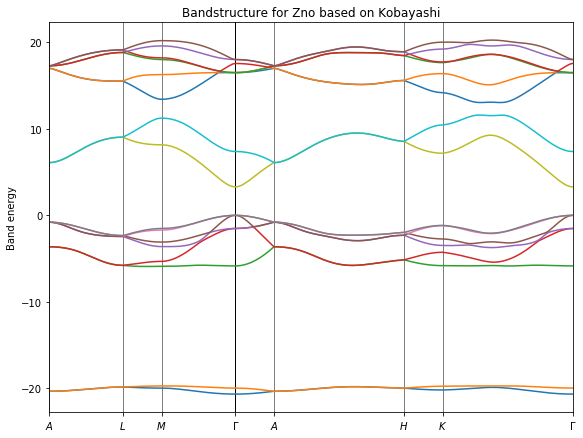

In [13]:
ZnO_tb.bandstructure()
plt.show()

In [46]:
class EELS:
    
    temperature = 0
    fermiEnergy = 0
    
    def __init__(self, crystal, name=None):
        self.crystal = crystal
        
    def setDiffractionZone(self, zone=None, bins=None):
        """ Define the resolution of the diffraction space, similar to the CCD in TEM
        
        :type  zone: ndarray
        :param zone: The range of the diffraction space, a value containing the full brillouin zone is calculated if no value given
        
        :type  bins: ndarray
        :param bins: The number of bins in diffraction space, a value corresponding to the resolution of the brillouin zone is calculated if no value given. Will allways round up to an odd number
        """
        if not zone:
            self.zone = np.max(np.abs(self.crystal.brillouinZone.lattice),axis=0)
        else:
            self.zone = zone
            
        if not bins:
            self.bins = np.round(self.crystal.brillouinZone.mesh).astype(int) #/1.3 is a bad temporarly solution
        else:
            self.bins = bins
        
        for i in range(len(self.bins)):
            if (self.bins[i]%2==0):
                self.bins[i] += 1
        

    def setMeta(self, name, authors, title=None, notes=None):
        self.name = name
        self.authors = authors
        
        if not title:
            self.title = self.name
        else:
            self.title = title
        
        if not notes:
            self.notes = "No notes provided."
        else:
            self.notes = notes
        
    def _createMeta(self):
        """ Generate and organize info into a matadata dictionary recognized by hyperspy
        :returns: nested dictionary of information """


        metadata = {}
        metadata['General'] = {}

        metadata['General']['name'] = self.name
        metadata['General']['title'] = self.title
        metadata['General']['authors'] = self.authors
        metadata['General']['notes'] = self.notes

        metadata['Signal'] = {}
        metadata['Signal']['binned'] = True
        metadata['Signal']['signal_type'] = None

        metadata['Sample'] = {}
        metadata['Sample']['elements'] = self.crystal.getAtomNumbers()


        metadata['Sample']['system'] = {}
        metadata['Sample']['system']['cell'] = {}
        axes = ['a','b','c']
        for i in range(len(self.cell.lattice)):
            metadata['Sample']['system']['cell'][axes[i]] = self.cell.lattice[i]

        metadata['Sample']['system']['fermiEnergy'] = self.fermiEnergy
        metadata['Sample']['system']['temperature'] = self.temperature

        metadata['Sample']['system']['model'] = self.crystal.brillouinZone.band_model
        metadata['Sample']['system']['bands']['count'] = len(self.crystal.brillouinZone.bands)
        metadata['Sample']['system']['bands'] = self.crystal.brillouinZone.bands
        
        metadata['Sample']['description'] = None

        return metadata


    def createSignal(self, data, eBin):
        """Organize and convert data and axes into a hyperspy signal 
        :param data: the resulting array from simulation
        :param eBin: the energy binning used in simulation
        :returns: hyperspy signal 
        """

        diffractionZone, diffractionBins = self.diffractionGrid()

        metadata = self.createMeta()

        s = hs.signals.BaseSignal(data, metadata=metadata)


        names = ["Energy", "q_x", "q_y", "q_z"]
        for i in range(len(data.shape)-1):
            name = names[i+1]
            s.axes_manager[2-i].name = name
            s.axes_manager[name].scale = diffractionZone[i]/(diffractionBins[i]-1)
            s.axes_manager[name].units = "AA-1"
            s.axes_manager[name].offset = -diffractionZone[i]/2
        i += 1
        name = names[0]
        s.axes_manager[i].name = name
        s.axes_manager[name].scale = eBin[1]-eBin[0]
        s.axes_manager[name].units = "eV"
        s.axes_manager[name].offset = eBin[0]
        #s.metadata.Signal.binned = True


        p = s.as_signal1D(-1)
        return p

    
    def calculateScatteringCrossSection(self, energyBins, fermiEnergy=None, temperature=None):
        """ Calculate the momentum dependent scattering cross section of the system,
        
        :type  energyBins: ndarray
        :param energyBins: The binning range 
        
        :type  fermiEnergy: float
        :param fermiEnergy: a spesific fermiEnergy in eV, if not defined the standard fermiEnergy is used
        
        :type  temperature: float
        :param temperature: a spesific temperature in Kelvin, if not defined the standard temperature is used
        """

        if temperature:
            self.temperature = temperature
        if fermiEnergy:
            self.fermiEnergy = fermiEnergy

        

        energyBands = []
        waveStates = []
        for band in self.bands:
            energyBands.append(band.energies)
            waveStates.append(band.waves)

        #data = _spectrum.calculate_spectrum(diffractionZone, diffractionBins, self.cell.brillouinZone, self.reciprocalGrid()[1], np.stack(energyBands, axis=1),  np.stack(waveStates, axis=1), energyBins, self.fermiEnergy, self.temperature)

        #return self.createSignal(data, energyBins)
        
    def multiCalculateScatteringCrossSection(self, num_threads, energyBins, fermiEnergy=None, temperature=None):
        if temperature:
            self.temperature = temperature
        if fermiEnergy:
            self.fermiEnergy = fermiEnergy

        self.energyBins = energyBins
        
        spectra = []

        def job(worker):
            i, f, initial_band, final_band = worker
            
            energyBands = [initial_band.energies, final_band.energies]
            waveStates =  [initial_band.waves, final_band.waves]
            
            signal = _spectrum.calculate_spectrum(
                self.zone, 
                self.bins, 
                self.crystal.brillouinZone.lattice, 
                self.crystal.brillouinZone.k_list,
                np.stack(energyBands, axis=1),  
                np.stack(waveStates, axis=1), 
                self.energyBins, 
                self.fermiEnergy, 
                self.temperature
            )

            with write_lock:
                spectra.append(thread_object(i, f, signal))

        def threader():
            while True:
                worker = q.get()
                job(worker)
                q.task_done()

        num_workers = 5

        write_lock = threading.Lock()

        q = Queue()

        for thread_index in range(num_threads):
            thread = threading.Thread(target = threader)
            thread.daemon = True
            thread.start()

        bands = self.crystal.brillouinZone.bands[2:11]
        
        for i, initial_band in enumerate(bands):
            for f, final_band in enumerate(bands[(i+1):]):
                f += (i+1)
                q.put((i, f, initial_band, final_band)) #check if worker can be tuple (initial,final)
        q.join()

        signal_total = spectra[0].signal
        for spectrum in spectra[1:]:
            signal_total += spectrum.signal
        
        return signal_total
        
        #sorted_spectra = sorted(spectra, key=lambda thread_object: thread_object.job_id)    
        

        
    def __repr__(self):
        string = "EELS Signal Calculator:\n\nSignal name:\n\t{}\nAuthors:\n\t{}\nTitle:\n\t{}\nNotes:\n\t{}\n\n".format(self.name, self.authors, self.title, self.notes)
        string += "Temperature: {} K\tFermiEnergy: {} eV\n".format(self.temperature, self.fermiEnergy)
        return string

In [47]:
import numpy as np
import threading
from queue import Queue
import time
import random

class thread_object:
    def __init__(self, initial_band, final_band, signal):
        """ Create instance of a thread object, helpes sorting data
        
        :type  signal: ndarray
        :param signal: the signal-array from code
        """
        self.initial_band = initial_band
        self.final_band = final_band
        self.signal = signal
    def __repr__(self):
        return "From {} to {}\n".format(self.initial_band, self.final_band)

In [48]:
TEM = EELS(ZnO)

In [49]:
TEM.setMeta(
name = "Test signal",
authors = "Sindre R. Bilden",
title = "Test signal title",
notes = "Some random words."
)

In [ ]:
TEM.multiCalculateScatteringCrossSection(num_threads=10, energyBins=np.linspace(0,5,100))

Exception in thread Thread-77:
Traceback (most recent call last):
  File "/home/sindrerb/anaconda3/envs/hySpy2/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindrerb/anaconda3/envs/hySpy2/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-46-350f1c5f9ed0>", line 184, in threader
    job(worker)
  File "<ipython-input-46-350f1c5f9ed0>", line 166, in job
    signal = _spectrum.calculate_spectrum(
NameError: name '_spectrum' is not defined
Exception in thread Thread-79:
Traceback (most recent call last):
  File "/home/sindrerb/anaconda3/envs/hySpy2/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindrerb/anaconda3/envs/hySpy2/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-46-350f1c5f9ed0>", line 184, in threader
    job(worker)
  File "<ipython-input-46-350f1c5f9ed0>", line 166,